In [131]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
from shapely.geometry import Point
import sys
import networkx as nx
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine.road_model import RoadModel, plot_correlation, plot_random_od

In [132]:
def create_zones_from_nodes(nodes,num_zones=100):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones

def main_strongly_connected_component(links, nodes=None, split_direction=False):
    graph = nx.DiGraph()
    graph.add_edges_from(links[['a', 'b']].values.tolist())
    if 'oneway' in links.columns and split_direction :
        graph.add_edges_from(
            links.loc[~links['oneway'].astype(bool)][['b', 'a']].values.tolist()
        )

    main_scc = None
    size = 0
    for scc in nx.strongly_connected_components(graph):
        if len(scc) > size :
            size = len(scc)
            main_scc = scc

    l = links.loc[links['a'].isin(main_scc) & links['b'].isin(main_scc)]
    if nodes is not None:
        n = nodes.loc[list(main_scc)]
        return l, n
    return l 


In [133]:
num_zones = 500
train_size = 2500
date_time = '2022-12-13T08:00:21-04:00'
ff_time_col = 'time'
max_speed = 100
num_cores = 4
hereApiKey= ''   

# read files

In [140]:
input_folder= '../../scenarios/atlanta/inputs/'

In [141]:
links = gpd.read_file(input_folder + 'road/road_links.geojson',engine='pyogrio')
links.set_index('index',inplace=True)
nodes = gpd.read_file(input_folder + 'road/road_nodes.geojson',engine='pyogrio')
nodes.set_index('index',inplace=True)

In [142]:
zones = create_zones_from_nodes(nodes,num_zones=num_zones)

In [143]:
self = RoadModel(links,nodes,zones,ff_time_col=ff_time_col)

In [144]:
self.split_quenedi_rlinks()

In [145]:
len(self.road_links)

71154

In [146]:
self.road_links,self.road_nodes=main_strongly_connected_component(self.road_links,self.road_nodes)

In [147]:
#remove NaN time. use 20kmh
print(len(self.road_links[self.road_links[self.ff_time_col].isnull()]),'links with null time. replace with 20kmh time')
self.road_links.loc[self.road_links[self.ff_time_col].isnull(),self.ff_time_col] = self.road_links.loc[self.road_links[self.ff_time_col].isnull(),'length']*3.6/20

0 links with null time. replace with 20kmh time


In [148]:
self.zones_nearest_node()
self.create_od_mat()

../../../quetzal/quetzal/engine/road_model.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid['geometry'] = centroid.centroid


max_distance found:  0.03264105029246454 degrees


In [149]:
print(len(self.od_time),'OD')
print(len(self.zones_centroid), 'zones')

249500 OD
500 zones


In [151]:
train_od = self.get_training_set(train_size=train_size,seed=42)

247005  OD to interpolate
2495  OD for training (API call)
1.0 % training
number of unique origin and destination in training set
497 496
max destination for an origin: 19


In [156]:

#read Here matrix
try:
    mat = pd.read_csv(input_folder + 'here_OD.csv')
    mat = mat.set_index('origin')
    mat.columns.name='destination'
except:
    mat = self.call_api_on_training_set(train_od,
                                         apiKey=hereApiKey,
                                         api='here',
                                         mode='car',
                                         time=date_time,
                                         saving=False)
    mat.to_csv(input_folder + 'here_OD.csv')

In [157]:
self.apply_api_matrix(mat,api_time_col='here_time')

6 unfound OD in the api call, they will be interpolated
od time applied on 2489
od to interpolate 247011


In [158]:
self.train_knn_model(weight='distance', n_neighbors=5)
self.predict_zones()

In [159]:
100/len(links)

0.0020236360692892992

In [160]:
%%time
err = self.apply_od_time_on_road_links(gap_limit=0.5,max_num_it=15, num_cores=num_cores, max_speed=max_speed,log_error=True)


0 2.44
1 3.49
2 2.92
3 2.71
4 2.57
5 2.48
6 2.42
7 2.37
8 2.33
9 2.3
10 2.27
11 2.25
12 2.23
13 2.22
14 2.2
15 2.19
66.1 % of links used
CPU times: user 1min 30s, sys: 6.04 s, total: 1min 36s
Wall time: 1min 9s


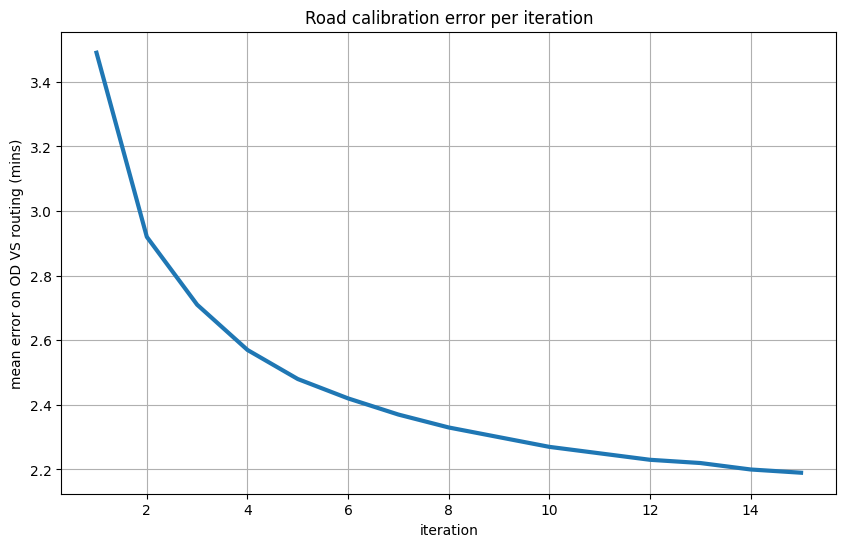

In [161]:
import matplotlib.pyplot as plt
if True:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot([x[0] for x in err[1:]],[x[1] for x in err[1:]],linewidth=3)
    plt.grid(True, 'major', linestyle='-', axis='both')
    ax.set_axisbelow(True)
    plt.xlabel('iteration')
    plt.title('Road calibration error per iteration')
    plt.ylabel('mean error on OD VS routing (mins)')
    #plt.savefig(figdir +'/error.png')

In [162]:
from io import BytesIO

Mean Absolute Error: 2.19 mins.


0

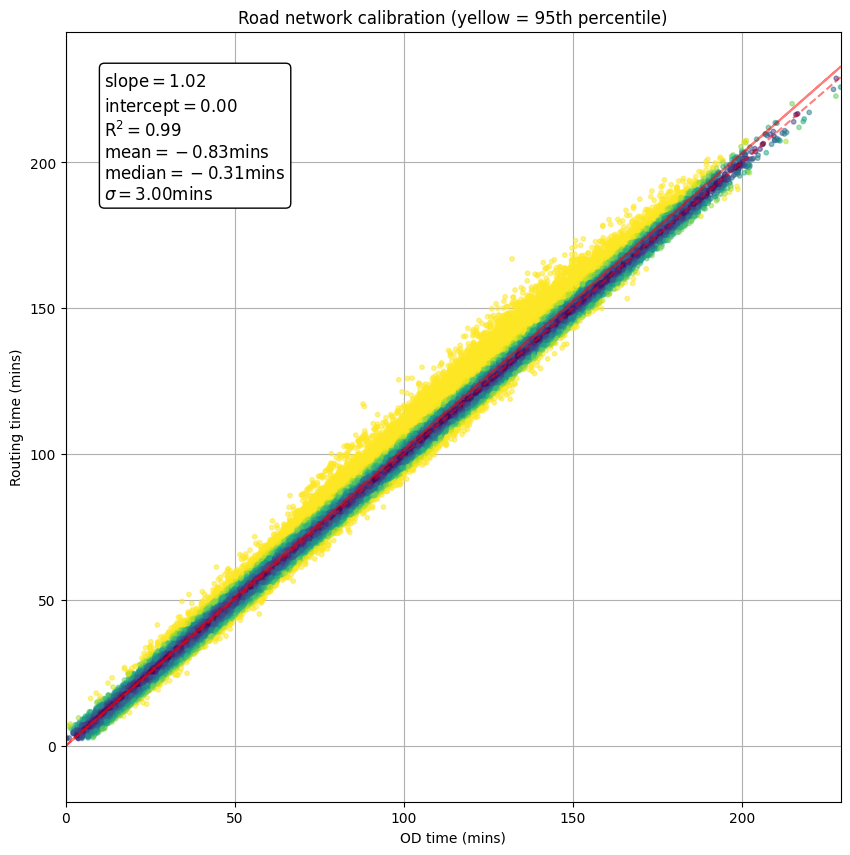

In [163]:
img_data = BytesIO()
plot_correlation(self.od_time['here_time']/60, 
                 self.od_time['routing_time']/60, 
                 alpha=0.5,
                 xlabel='OD time (mins)', 
                 ylabel='Routing time (mins)',
                 title = 'Road network calibration (yellow = 95th percentile)')
plt.savefig(img_data, format='png')
img_data.seek(0)

In [164]:
self.merge_quenedi_rlinks()

In [165]:
%matplotlib inline

Text(0.5, 1.0, 'Zones Centroids')

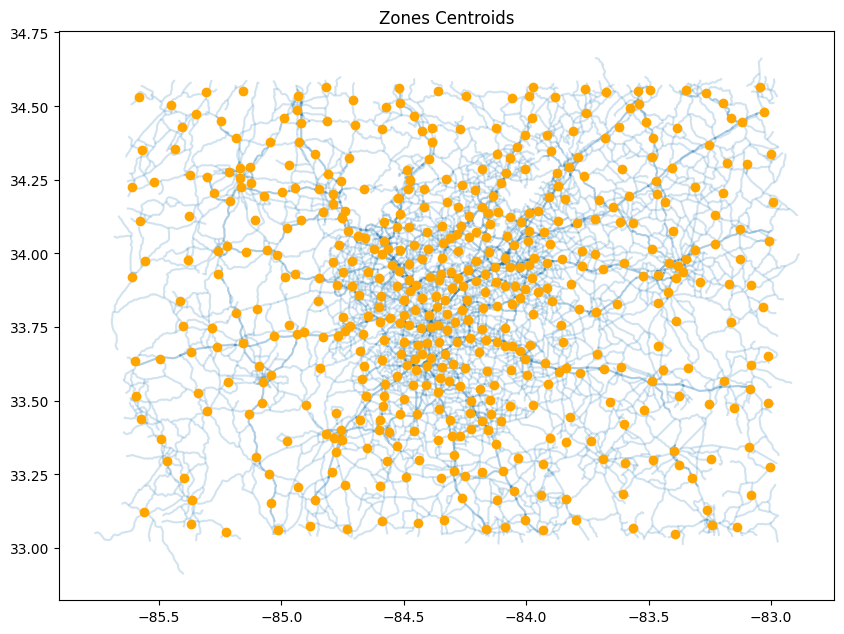

In [166]:
fig, ax = plt.subplots(figsize=(10,10))
self.road_links.plot(ax=ax,alpha=0.2,zorder=1)
self.zones_centroid.plot(ax=ax,color='orange',zorder=2)
plt.title('Zones Centroids')
#plt.savefig(figdir +'/zones.png')

/home/boivin/.local/share/virtualenvs/quetzal-77-onnKO/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


CPU times: user 28.8 s, sys: 421 ms, total: 29.3 s
Wall time: 28.9 s


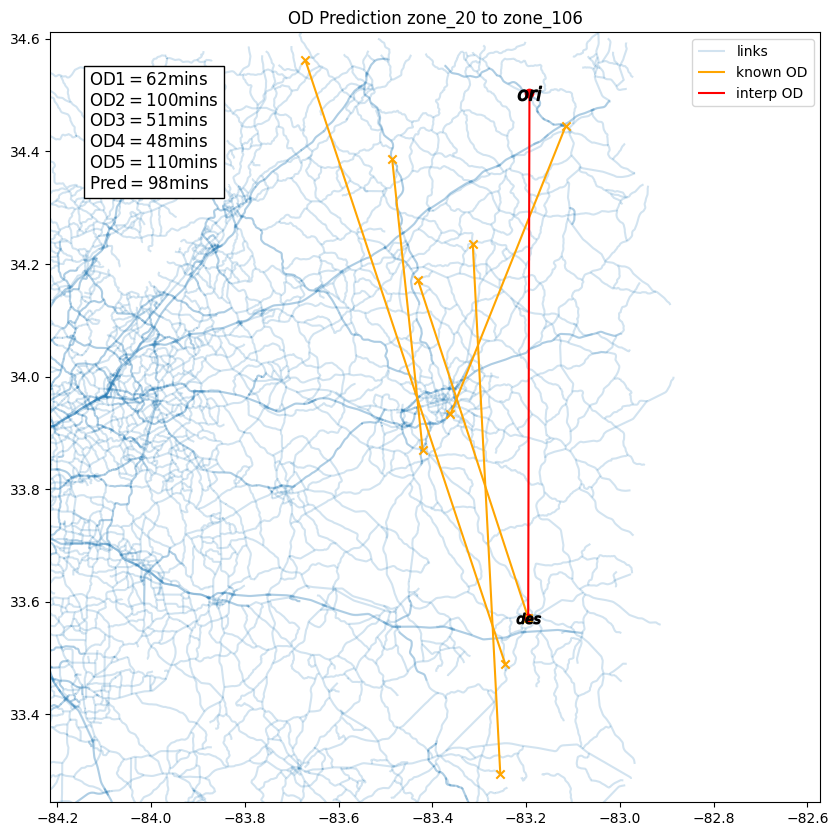

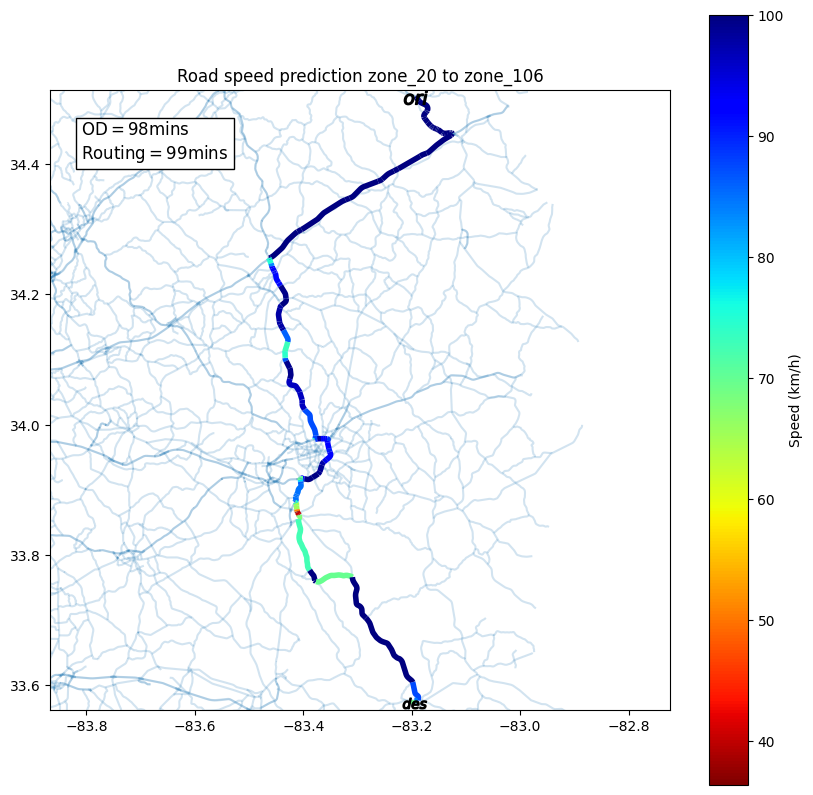

In [130]:
%%time
f,f2=plot_random_od(self,43)

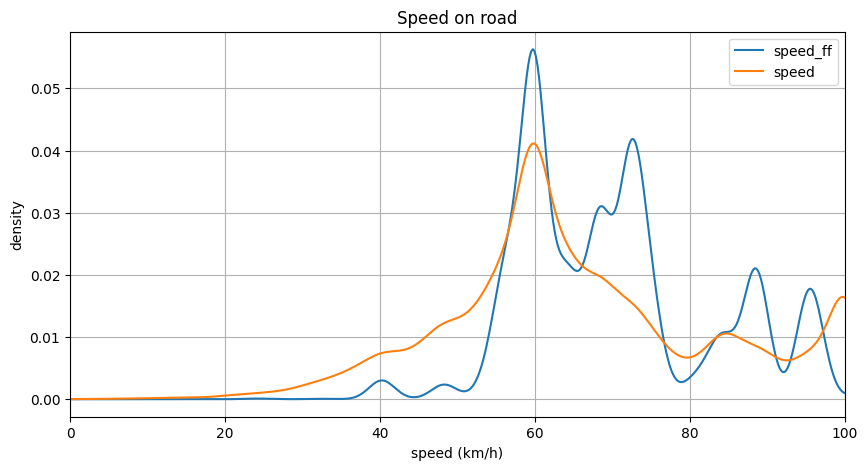

In [174]:
fig, ax = plt.subplots(figsize=(10,5))
import scipy.stats as stats
x=np.linspace(0, 100, 500)
density = stats.gaussian_kde(self.road_links['speed'])
plt.plot(x,density(x))
density = stats.gaussian_kde(self.road_links[np.isfinite(self.road_links['here_speed'])]['here_speed'])
plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,100])
plt.legend(['speed_ff', 'speed'])
plt.xlabel('speed (km/h)')
plt.ylabel('density')

plt.title('Speed on road')
plt.show()

In [182]:
#fig, ax = plt.subplots(figsize=(10,10))
#self.road_links.plot(ax=ax,column='here_speed',legend=True,linewidth=2,cmap='jet_r')
#plt.title('Speed (km/h)')


In [187]:
self.road_links.to_file(input_folder + 'road/road_links.geojson',engine='pyogrio',driver='GeoJSON')